In [1]:
import numpy as np
from numpy.linalg import inv, norm, lstsq
from numpy.linalg import matrix_rank as rank
from PIL import Image
import cv2

In [2]:
class MatlabCp2tormException(Exception):
    def __str__(self):
        return 'In File {}:{}'.format(
                __file__, super.__str__(self))

def tformfwd(trans, uv):
    """
    Function:
    ----------
        apply affine transform 'trans' to uv
    Parameters:
    ----------
        @trans: 3x3 np.array
            transform matrix
        @uv: Kx2 np.array
            each row is a pair of coordinates (x, y)
    Returns:
    ----------
        @xy: Kx2 np.array
            each row is a pair of transformed coordinates (x, y)
    """
    uv = np.hstack((
        uv, np.ones((uv.shape[0], 1))
    ))
    xy = np.dot(uv, trans)
    xy = xy[:, 0:-1]
    return xy


def tforminv(trans, uv):
    """
    Function:
    ----------
        apply the inverse of affine transform 'trans' to uv
    Parameters:
    ----------
        @trans: 3x3 np.array
            transform matrix
        @uv: Kx2 np.array
            each row is a pair of coordinates (x, y)
    Returns:
    ----------
        @xy: Kx2 np.array
            each row is a pair of inverse-transformed coordinates (x, y)
    """
    Tinv = inv(trans)
    xy = tformfwd(Tinv, uv)
    return xy


def findNonreflectiveSimilarity(uv, xy, options=None):

    options = {'K': 2}

    K = options['K']
    M = xy.shape[0]
    x = xy[:, 0].reshape((-1, 1))  # use reshape to keep a column vector
    y = xy[:, 1].reshape((-1, 1))  # use reshape to keep a column vector
    # print('--->x, y:\n', x, y

    tmp1 = np.hstack((x, y, np.ones((M, 1)), np.zeros((M, 1))))
    tmp2 = np.hstack((y, -x, np.zeros((M, 1)), np.ones((M, 1))))
    X = np.vstack((tmp1, tmp2))
    # print('--->X.shape: ', X.shape
    # print('X:\n', X

    u = uv[:, 0].reshape((-1, 1))  # use reshape to keep a column vector
    v = uv[:, 1].reshape((-1, 1))  # use reshape to keep a column vector
    U = np.vstack((u, v))
    # print('--->U.shape: ', U.shape
    # print('U:\n', U

    # We know that X * r = U
    if rank(X) >= 2 * K:
        r, _, _, _ = lstsq(X, U)
        r = np.squeeze(r)
    else:
        raise Exception('cp2tform:twoUniquePointsReq')

    # print('--->r:\n', r

    sc = r[0]
    ss = r[1]
    tx = r[2]
    ty = r[3]

    Tinv = np.array([
        [sc, -ss, 0],
        [ss,  sc, 0],
        [tx,  ty, 1]
    ])

    # print('--->Tinv:\n', Tinv

    T = inv(Tinv)
    # print('--->T:\n', T

    T[:, 2] = np.array([0, 0, 1])

    return T, Tinv


def findSimilarity(uv, xy, options=None):

    options = {'K': 2}

#    uv = np.array(uv)
#    xy = np.array(xy)

    # Solve for trans1
    trans1, trans1_inv = findNonreflectiveSimilarity(uv, xy, options)

    # Solve for trans2

    # manually reflect the xy data across the Y-axis
    xyR = xy
    xyR[:, 0] = -1 * xyR[:, 0]

    trans2r, trans2r_inv = findNonreflectiveSimilarity(uv, xyR, options)

    # manually reflect the tform to undo the reflection done on xyR
    TreflectY = np.array([
        [-1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ])

    trans2 = np.dot(trans2r, TreflectY)

    # Figure out if trans1 or trans2 is better
    xy1 = tformfwd(trans1, uv)
    norm1 = norm(xy1 - xy)

    xy2 = tformfwd(trans2, uv)
    norm2 = norm(xy2 - xy)

    if norm1 <= norm2:
        return trans1, trans1_inv
    else:
        trans2_inv = inv(trans2)
        return trans2, trans2_inv


def get_similarity_transform(src_pts, dst_pts, reflective=True):
    """
    Function:
    ----------
        Find Similarity Transform Matrix 'trans':
            u = src_pts[:, 0]
            v = src_pts[:, 1]
            x = dst_pts[:, 0]
            y = dst_pts[:, 1]
            [x, y, 1] = [u, v, 1] * trans
    Parameters:
    ----------
        @src_pts: Kx2 np.array
            source points, each row is a pair of coordinates (x, y)
        @dst_pts: Kx2 np.array
            destination points, each row is a pair of transformed
            coordinates (x, y)
        @reflective: True or False
            if True:
                use reflective similarity transform
            else:
                use non-reflective similarity transform
    Returns:
    ----------
       @trans: 3x3 np.array
            transform matrix from uv to xy
        trans_inv: 3x3 np.array
            inverse of trans, transform matrix from xy to uv
    """

    if reflective:
        trans, trans_inv = findSimilarity(src_pts, dst_pts)
    else:
        trans, trans_inv = findNonreflectiveSimilarity(src_pts, dst_pts)

    return trans, trans_inv


def cvt_tform_mat_for_cv2(trans):
    """
    Function:
    ----------
        Convert Transform Matrix 'trans' into 'cv2_trans' which could be
        directly used by cv2.warpAffine():
            u = src_pts[:, 0]
            v = src_pts[:, 1]
            x = dst_pts[:, 0]
            y = dst_pts[:, 1]
            [x, y].T = cv_trans * [u, v, 1].T
    Parameters:
    ----------
        @trans: 3x3 np.array
            transform matrix from uv to xy
    Returns:
    ----------
        @cv2_trans: 2x3 np.array
            transform matrix from src_pts to dst_pts, could be directly used
            for cv2.warpAffine()
    """
    cv2_trans = trans[:, 0:2].T

    return cv2_trans


def get_similarity_transform_for_cv2(src_pts, dst_pts, reflective=True):
    """
    Function:
    ----------
        Find Similarity Transform Matrix 'cv2_trans' which could be
        directly used by cv2.warpAffine():
            u = src_pts[:, 0]
            v = src_pts[:, 1]
            x = dst_pts[:, 0]
            y = dst_pts[:, 1]
            [x, y].T = cv_trans * [u, v, 1].T
    Parameters:
    ----------
        @src_pts: Kx2 np.array
            source points, each row is a pair of coordinates (x, y)
        @dst_pts: Kx2 np.array
            destination points, each row is a pair of transformed
            coordinates (x, y)
        reflective: True or False
            if True:
                use reflective similarity transform
            else:
                use non-reflective similarity transform
    Returns:
    ----------
        @cv2_trans: 2x3 np.array
            transform matrix from src_pts to dst_pts, could be directly used
            for cv2.warpAffine()
    """
    trans, trans_inv = get_similarity_transform(src_pts, dst_pts, reflective)
    cv2_trans = cvt_tform_mat_for_cv2(trans)

    return cv2_trans


# reference facial points, a list of coordinates (x,y)
REFERENCE_FACIAL_POINTS = [
    [30.29459953,  51.69630051],
    [65.53179932,  51.50139999],
    [48.02519989,  71.73660278],
    [33.54930115,  92.3655014],
    [62.72990036,  92.20410156]
]

DEFAULT_CROP_SIZE = (96, 112)


class FaceWarpException(Exception):
    def __str__(self):
        return 'In File {}:{}'.format(
            __file__, super.__str__(self))


def get_reference_facial_points(output_size=None,
                                inner_padding_factor=0.0,
                                outer_padding=(0, 0),
                                default_square=False):
    """
    Function:
    ----------
        get reference 5 key points according to crop settings:
        0. Set default crop_size:
            if default_square: 
                crop_size = (112, 112)
            else: 
                crop_size = (96, 112)
        1. Pad the crop_size by inner_padding_factor in each side;
        2. Resize crop_size into (output_size - outer_padding*2),
            pad into output_size with outer_padding;
        3. Output reference_5point;
    Parameters:
    ----------
        @output_size: (w, h) or None
            size of aligned face image
        @inner_padding_factor: (w_factor, h_factor)
            padding factor for inner (w, h)
        @outer_padding: (w_pad, h_pad)
            each row is a pair of coordinates (x, y)
        @default_square: True or False
            if True:
                default crop_size = (112, 112)
            else:
                default crop_size = (96, 112);
        !!! make sure, if output_size is not None:
                (output_size - outer_padding) 
                = some_scale * (default crop_size * (1.0 + inner_padding_factor))
    Returns:
    ----------
        @reference_5point: 5x2 np.array
            each row is a pair of transformed coordinates (x, y)
    """
    # print('\n===> get_reference_facial_points():')

    # print('---> Params:')
    # print('            output_size: ', output_size)
    # print('            inner_padding_factor: ', inner_padding_factor)
    # print('            outer_padding:', outer_padding)
    # print('            default_square: ', default_square)

    tmp_5pts = np.array(REFERENCE_FACIAL_POINTS)
    tmp_crop_size = np.array(DEFAULT_CROP_SIZE)

    # 0) make the inner region a square
    if default_square:
        size_diff = max(tmp_crop_size) - tmp_crop_size
        tmp_5pts += size_diff / 2
        tmp_crop_size += size_diff

    # print('---> default:')
    # print('              crop_size = ', tmp_crop_size)
    # print('              reference_5pts = ', tmp_5pts)

    if (output_size and
            output_size[0] == tmp_crop_size[0] and
            output_size[1] == tmp_crop_size[1]):
        # print('output_size == DEFAULT_CROP_SIZE {}: return default reference points'.format(tmp_crop_size))
        return tmp_5pts

    if (inner_padding_factor == 0 and
            outer_padding == (0, 0)):
        if output_size is None:
            # print('No paddings to do: return default reference points')
            return tmp_5pts
        else:
            raise FaceWarpException(
                'No paddings to do, output_size must be None or {}'.format(tmp_crop_size))

    # check output size
    if not (0 <= inner_padding_factor <= 1.0):
        raise FaceWarpException('Not (0 <= inner_padding_factor <= 1.0)')

    if ((inner_padding_factor > 0 or outer_padding[0] > 0 or outer_padding[1] > 0)
            and output_size is None):
        output_size = tmp_crop_size * \
            (1 + inner_padding_factor * 2).astype(np.int32)
        output_size += np.array(outer_padding)
        # print('              deduced from paddings, output_size = ', output_size)

    if not (outer_padding[0] < output_size[0]
            and outer_padding[1] < output_size[1]):
        raise FaceWarpException('Not (outer_padding[0] < output_size[0]'
                                'and outer_padding[1] < output_size[1])')

    # 1) pad the inner region according inner_padding_factor
    # print('---> STEP1: pad the inner region according inner_padding_factor')
    if inner_padding_factor > 0:
        size_diff = tmp_crop_size * inner_padding_factor * 2
        tmp_5pts += size_diff / 2
        tmp_crop_size += np.round(size_diff).astype(np.int32)

    # print('              crop_size = ', tmp_crop_size)
    # print('              reference_5pts = ', tmp_5pts)

    # 2) resize the padded inner region
    # print('---> STEP2: resize the padded inner region')
    size_bf_outer_pad = np.array(output_size) - np.array(outer_padding) * 2
    # print('              crop_size = ', tmp_crop_size)
    # print('              size_bf_outer_pad = ', size_bf_outer_pad)

    if size_bf_outer_pad[0] * tmp_crop_size[1] != size_bf_outer_pad[1] * tmp_crop_size[0]:
        raise FaceWarpException('Must have (output_size - outer_padding)'
                                '= some_scale * (crop_size * (1.0 + inner_padding_factor)')

    scale_factor = size_bf_outer_pad[0].astype(np.float32) / tmp_crop_size[0]
    # print('              resize scale_factor = ', scale_factor)
    tmp_5pts = tmp_5pts * scale_factor
#    size_diff = tmp_crop_size * (scale_factor - min(scale_factor))
#    tmp_5pts = tmp_5pts + size_diff / 2
    tmp_crop_size = size_bf_outer_pad
    # print('              crop_size = ', tmp_crop_size)
    # print('              reference_5pts = ', tmp_5pts)

    # 3) add outer_padding to make output_size
    reference_5point = tmp_5pts + np.array(outer_padding)
    tmp_crop_size = output_size
    # print('---> STEP3: add outer_padding to make output_size')
    # print('              crop_size = ', tmp_crop_size)
    # print('              reference_5pts = ', tmp_5pts)

    # print('===> end get_reference_facial_points\n')

    return reference_5point


def get_affine_transform_matrix(src_pts, dst_pts):
    """
    Function:
    ----------
        get affine transform matrix 'tfm' from src_pts to dst_pts
    Parameters:
    ----------
        @src_pts: Kx2 np.array
            source points matrix, each row is a pair of coordinates (x, y)
        @dst_pts: Kx2 np.array
            destination points matrix, each row is a pair of coordinates (x, y)
    Returns:
    ----------
        @tfm: 2x3 np.array
            transform matrix from src_pts to dst_pts
    """

    tfm = np.float32([[1, 0, 0], [0, 1, 0]])
    n_pts = src_pts.shape[0]
    ones = np.ones((n_pts, 1), src_pts.dtype)
    src_pts_ = np.hstack([src_pts, ones])
    dst_pts_ = np.hstack([dst_pts, ones])

#    #print(('src_pts_:\n' + str(src_pts_))
#    #print(('dst_pts_:\n' + str(dst_pts_))

    A, res, rank, s = np.linalg.lstsq(src_pts_, dst_pts_)

#    #print(('np.linalg.lstsq return A: \n' + str(A))
#    #print(('np.linalg.lstsq return res: \n' + str(res))
#    #print(('np.linalg.lstsq return rank: \n' + str(rank))
#    #print(('np.linalg.lstsq return s: \n' + str(s))

    if rank == 3:
        tfm = np.float32([
            [A[0, 0], A[1, 0], A[2, 0]],
            [A[0, 1], A[1, 1], A[2, 1]]
        ])
    elif rank == 2:
        tfm = np.float32([
            [A[0, 0], A[1, 0], 0],
            [A[0, 1], A[1, 1], 0]
        ])

    return tfm


def warp_and_crop_face(src_img,
                       facial_pts,
                       reference_pts=None,
                       crop_size=(96, 112),
                       align_type='smilarity'):
    """
    Function:
    ----------
        apply affine transform 'trans' to uv
    Parameters:
    ----------
        @src_img: 3x3 np.array
            input image
        @facial_pts: could be
            1)a list of K coordinates (x,y)
        or
            2) Kx2 or 2xK np.array
            each row or col is a pair of coordinates (x, y)
        @reference_pts: could be
            1) a list of K coordinates (x,y)
        or
            2) Kx2 or 2xK np.array
            each row or col is a pair of coordinates (x, y)
        or
            3) None
            if None, use default reference facial points
        @crop_size: (w, h)
            output face image size
        @align_type: transform type, could be one of
            1) 'similarity': use similarity transform
            2) 'cv2_affine': use the first 3 points to do affine transform,
                    by calling cv2.getAffineTransform()
            3) 'affine': use all points to do affine transform
    Returns:
    ----------
        @face_img: output face image with size (w, h) = @crop_size
    """

    if reference_pts is None:
        if crop_size[0] == 96 and crop_size[1] == 112:
            reference_pts = REFERENCE_FACIAL_POINTS
        else:
            default_square = False
            inner_padding_factor = 0
            outer_padding = (0, 0)
            output_size = crop_size

            reference_pts = get_reference_facial_points(output_size,
                                                        inner_padding_factor,
                                                        outer_padding,
                                                        default_square)

    ref_pts = np.float32(reference_pts)
    ref_pts_shp = ref_pts.shape
    if max(ref_pts_shp) < 3 or min(ref_pts_shp) != 2:
        raise FaceWarpException(
            'reference_pts.shape must be (K,2) or (2,K) and K>2')

    if ref_pts_shp[0] == 2:
        ref_pts = ref_pts.T

    src_pts = np.float32(facial_pts)
    src_pts_shp = src_pts.shape
    if max(src_pts_shp) < 3 or min(src_pts_shp) != 2:
        raise FaceWarpException(
            'facial_pts.shape must be (K,2) or (2,K) and K>2')

    if src_pts_shp[0] == 2:
        src_pts = src_pts.T

#    #print('--->src_pts:\n', src_pts
#    #print('--->ref_pts\n', ref_pts

    if src_pts.shape != ref_pts.shape:
        raise FaceWarpException(
            'facial_pts and reference_pts must have the same shape')

    if align_type == 'cv2_affine':
        tfm = cv2.getAffineTransform(src_pts[0:3], ref_pts[0:3])
#        #print(('cv2.getAffineTransform() returns tfm=\n' + str(tfm))
    elif align_type == 'affine':
        tfm = get_affine_transform_matrix(src_pts, ref_pts)
#        #print(('get_affine_transform_matrix() returns tfm=\n' + str(tfm))
    else:
        tfm = get_similarity_transform_for_cv2(src_pts, ref_pts)
#        #print(('get_similarity_transform_for_cv2() returns tfm=\n' + str(tfm))

#    #print('--->Transform matrix: '
#    #print(('type(tfm):' + str(type(tfm)))
#    #print(('tfm.dtype:' + str(tfm.dtype))
#    #print( tfm

    face_img = cv2.warpAffine(src_img, tfm, (crop_size[0], crop_size[1]))

    return face_img


def allign_face(
    image: Image.Image,
    bounding_box: np.ndarray,
    landmarks: np.ndarray,
    crop_size: tuple[int, int]=(112, 112),
) -> Image.Image:

    reference = get_reference_facial_points(default_square=True)
    # facial5points = [[landmarks[j], landmarks[j + 5]] for j in range(5)]
    facial5points = landmarks
    warped_face = warp_and_crop_face(
        np.array(image), facial5points, reference, crop_size=crop_size)
    return Image.fromarray(warped_face)

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

path_to_detector = 'yolo11m-pose.pt_2024_08_07_fold_1/runs/pose/train/weights/best.pt'

path_to_image = 'image.png'
detector = YOLO(path_to_detector, verbose=False)
image = Image.open(path_to_image)
detector_results = detector(image, verbose=False)[0].cpu().numpy()

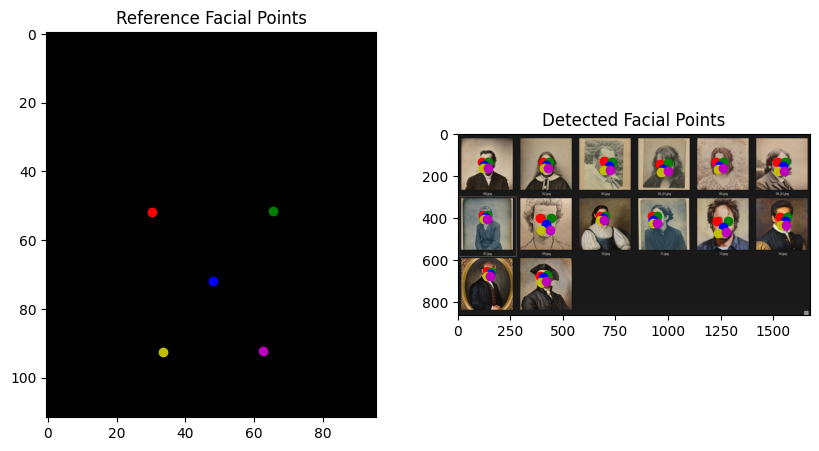

In [4]:
fig, (ax_reference, ax_image) = plt.subplots(1, 2, figsize=(10, 5))

ax_reference.set_title('Reference Facial Points')
ax_reference.imshow(np.zeros((112, 96, 3), dtype=np.uint8))
ax_reference.plot(REFERENCE_FACIAL_POINTS[0][0], REFERENCE_FACIAL_POINTS[0][1], 'ro')
ax_reference.plot(REFERENCE_FACIAL_POINTS[1][0], REFERENCE_FACIAL_POINTS[1][1], 'go')
ax_reference.plot(REFERENCE_FACIAL_POINTS[2][0], REFERENCE_FACIAL_POINTS[2][1], 'bo')
ax_reference.plot(REFERENCE_FACIAL_POINTS[3][0], REFERENCE_FACIAL_POINTS[3][1], 'yo')
ax_reference.plot(REFERENCE_FACIAL_POINTS[4][0], REFERENCE_FACIAL_POINTS[4][1], 'mo')

ax_image.set_title('Detected Facial Points')
ax_image.imshow(image)
for face in detector_results.keypoints.xy:
    ax_image.plot(face[0, 0], face[0, 1], 'ro')
    ax_image.plot(face[1, 0], face[1, 1], 'go')
    ax_image.plot(face[2, 0], face[2, 1], 'bo')
    ax_image.plot(face[3, 0], face[3, 1], 'yo')
    ax_image.plot(face[4, 0], face[4, 1], 'mo')

In [5]:
extracted_faces = [allign_face(image, None, face) for face in detector_results.keypoints.xy]

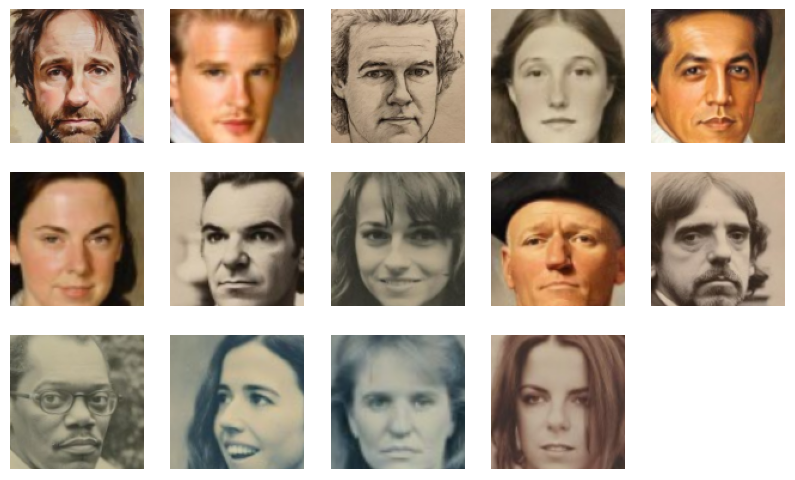

In [6]:
n_rows = int(len(extracted_faces) ** 0.5)
n_cols = int(len(extracted_faces) / n_rows + 1)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows))
for ax in axs.flatten():
    ax.axis('off')
for face, ax in zip(extracted_faces, axs.flatten()):
    ax.imshow(face)